<h1>Walmart Sales Forecating Problem</h1>

<h2>Need For Sales Forecasting</h2>

Sales Forecasting is a very Important area in Field of business Management.It helps  the store retailers to maintain there Stocks according to demand they are expecting,thus maximizig there profit and minimise burden of management of product stocks.
It is simalar to weather forecasting as both types of forecasting rely on science and historical data.<br/> While a wrong weather forecast may result in you carrying around an umbrella on a sunny day, inaccurate business forecasts could result in actual or opportunity losses.<br/>
Forecasting can drive sales by processing just-in-time orders efficiently.

<h2>Problem Statement</h2>

We have Sales data for Walmart Stores in 3 states(California,Texas,Wisconsin) for 3 categoies of data (HOBBIES,FOOD,HOSEHOLD) from year 2011 to 2016.We want to use this data to predict sales for next 28 days using several ML techniques.

<h2>Dataset</h2>

We have taken dataset from kaggle Competition named "M5 Forecasting - Accuracy Estimate the unit sales of Walmart retail goods"

We have been given sales of product for 1913 days amd we need to predict sales of next 28 days for each product. 

We have been given several Dataframes Like:-<br/>
1. <b>calendar.csv</b> - Contains information about the dates on which the products are sold.<br/>
2. <b>sales_train_validation.csv</b> - Contains the historical daily unit sales data per product and store [d_1 - d_1913].<br/>
3. <b>sell_prices.csv</b> - Contains information about the price of the products sold per store and date.<br/>
4. <b>sales_train_evaluation.csv</b> - Includes sales [d_1 - d_1941](we will use from d_1914-d_1941 for test data).<br/>

<b>Note:-</b> While Evaluating Model we are constructing 42840 time series and then calculate WRMSSSE on these series.
<br/>Series are given as follows:-

<img src='images/series1.PNG'>
<img src='images/series2.PNG'>

<h2> This is how data is organised</h2>
<img src='images/OrganisedData.PNG'>

<h2>Metric Used</h2>

1. Here We are use Weighted Root Mean Squared Scaled Error(WRMSSE).
2. We have used WRMSSE instead of Simple RMSE(Root Mean Squared Error) because in this dataset there are lot of zero sales so even if our model predicts most sales near to zero our model will give good performance,WRMSSE takes this in account.
3. Also WRMSSE is scaled independent and thus is mot effected by scale of each sries.
4. It is also a symmetric Metric as it penalizes all positive,negative,large as well as positive forecast
5. It is given as:-

<img src='images/RMSSE.JPG'>

<img src='images/rmse.PNG'>

<h2>Straing SALES FORECATING</h2>

**Reading all required packages and libraries**

In [1]:
#Import All required packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import multiprocessing as mp
from tqdm import tqdm

In [2]:
#Reading all the Data using pandas
df=pd.read_csv('calendar.csv')
df1=pd.read_csv('sales_train_validation.csv') #this is used for training
df2=pd.read_csv('sell_prices.csv')
df3=pd.read_csv('sales_train_evaluation.csv') # this is used for testing

In [3]:
df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


**OBSERVATION**
1. There are many entries which contain NaN in event_type_1,event_type_2,event_name_1 & enent_name_2 

In [4]:
df1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


**OBSERVATION**
1. We have sales for 1941 days.

In [5]:
df3.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


**OBSERVATION**
1. Here we have data for 1947 data. we will use this dataframe for testing.

In [6]:
df2.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
print("Shape of calender.csv",df.shape)
print("Shape of sales train validation.csv",df1.shape)
print("Shape of sell_price.csv",df2.shape)
print("Shape of sales train evaluation.csv",df3.shape)

Shape of calender.csv (1969, 14)
Shape of sales train validation.csv (30490, 1919)
Shape of sell_price.csv (6841121, 4)
Shape of sales train evaluation.csv (30490, 1947)


In [8]:
#Clearly in calender.csv we have many entries which contain NaN in event_type_1,event_type_2,event_name_1 & enent_name_2
#I have replaced all those entries with no_event
df=df.fillna(value='no_event')

In [9]:
df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,no_event,no_event,no_event,no_event,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,no_event,no_event,no_event,no_event,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,no_event,no_event,no_event,no_event,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,no_event,no_event,no_event,no_event,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,no_event,no_event,no_event,no_event,1,0,1


<h3>Preparing Data in Form one of Single DataFrame(Both Train,Testing,And For Private Score in Kaggle)</h3>

In [10]:
# https://www.geeksforgeeks.org/python-pandas-melt/#:~:text=melt()%20function%20is%20useful,identifier%20columns%2C%20variable%20and%20value.
# Since we need to have days as particular columns I have modified train_evaluation.csv and assigned changed structure of it
# I have created d and sales which contains sales for that day 
# This Increases size of csv file drastically

l=[]
for i in range(1,1914):
  l.append("d_"+str(i))
df_final=pd.melt(df1,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],\
                 value_vars=l,var_name="d",value_name="sales")

In [11]:
#here I am taking only last 28 data days of test bcz eariler values are same as for train
l=[]
for i in range(1914,1942):
  l.append("d_"+str(i))
df_final_test=pd.melt(df3,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],\
                 value_vars=l,var_name="d",value_name="sales")

In [12]:
for i in range(1942,1970):
    df3['d_'+str(i)]=0

In [13]:
#Also create future data to be used for futures sales data
l=[]
for i in range(1942,1970):
    l.append("d_"+str(i))
df_future_data=pd.melt(df3,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],\
                 value_vars=l,var_name="d",value_name="sales")    

In [14]:
#Now we merge all These 3 dataframes to get final csv file train
data=df_final.merge(df,on='d',copy=False)# combine calender.csv and modified trainevaluation.csv on feature 'd'
data=data.merge(df2,on=["store_id", "item_id", "wm_yr_wk"],copy=False) # combine new dataframe with sell_price.csv usnig features "store_id", "item_id", "wm_yr_wk"
# I am storing this final dataframe to final_dataframe.csv
data.to_csv('final_dataframe.csv',index=False)

In [15]:
#Now we merge all These 3 dataframes to get final csv file test
data_test=df_final_test.merge(df,on='d',copy=False)# combine calender.csv and modified trainevaluation.csv on feature 'd'
data_test=data_test.merge(df2,on=["store_id", "item_id", "wm_yr_wk"],copy=False) # combine new dataframe with sell_price.csv usnig features "store_id", "item_id", "wm_yr_wk"
# I am storing this final dataframe to final_dataframe.csv
data_test.to_csv('final_dataframe_test.csv',index=False)

In [16]:
#Now we merge all These 3 dataframes to get final csv file future data
data_future=df_future_data.merge(df,on='d',copy=False)# combine calender.csv and modified trainevaluation.csv on feature 'd'
data_future=data_future.merge(df2,on=["store_id", "item_id", "wm_yr_wk"],copy=False) # combine new dataframe with sell_price.csv usnig features "store_id", "item_id", "wm_yr_wk"
# I am storing this final dataframe to final_future_data.csv
data_future.fillna('no_event',inplace=True)
data_future.to_csv('final_future_data.csv',index=False)

In [17]:
print("Shape of final dataframe train is=",data.shape)
print("Shape of final dataframe test is=",data_test.shape)

Shape of final dataframe train is= (46027957, 22)
Shape of final dataframe test is= (853720, 22)


**Clearly this is huge amount of data**

In [ ]:
#reading up complete dataframe
data=pd.read_csv('final_dataframe.csv')
data_test=pd.read_csv('final_dataframe_test.csv')

<h1>Exploring various properties of DataFrame</h1> 

In [18]:
print("Head rows of Final DataFrame train")
data.head()

Head rows of Final DataFrame train


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.46
1,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.46
2,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.46
3,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,11101,...,2,2011,no_event,no_event,no_event,no_event,1,1,0,0.46
4,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,11101,...,2,2011,no_event,no_event,no_event,no_event,1,0,1,0.46


In [19]:
print("Colums present in dataFrame are",data.columns.values)

Colums present in dataFrame are ['id' 'item_id' 'dept_id' 'cat_id' 'store_id' 'state_id' 'd' 'sales'
 'date' 'wm_yr_wk' 'weekday' 'wday' 'month' 'year' 'event_name_1'
 'event_type_1' 'event_name_2' 'event_type_2' 'snap_CA' 'snap_TX'
 'snap_WI' 'sell_price']


In [20]:
print("Complete information about data Frame is:-\n")
print(data.info())

Complete information about data Frame is:-

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   d             object 
 7   sales         int64  
 8   date          object 
 9   wm_yr_wk      int64  
 10  weekday       object 
 11  wday          int64  
 12  month         int64  
 13  year          int64  
 14  event_name_1  object 
 15  event_type_1  object 
 16  event_name_2  object 
 17  event_type_2  object 
 18  snap_CA       int64  
 19  snap_TX       int64  
 20  snap_WI       int64  
 21  sell_price    float64
dtypes: float64(1), int64(8), object(13)
memory usage: 7.9+ GB
None


<b>Clearly this data frame is using a lot memory(7.7+GB) so we will try to remove unnecessary features
    while doing Feature Engineering </b>

In [21]:
print("There are these unique stores in this data=",data['store_id'].unique())

There are these unique stores in this data= ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']


In [22]:
print("There are these sates in data=",data['state_id'].unique())

There are these sates in data= ['CA' 'TX' 'WI']


In [23]:
print("Unique values of wday features=",data['wday'].unique())
print("Unique values of weekday features=",data['weekday'].unique())

Unique values of wday features= [1 2 3 4 5 6 7]
Unique values of weekday features= ['Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday']


<b>1. From this i get that 1 in wday corresponds to Saturday in weekday,2 for Sunday and so on.</b>

In [24]:
print("years for which I have this sales data=",data['year'].unique())

years for which I have this sales data= [2011 2012 2013 2014 2015 2016]


In [25]:
print("Months in year 2016 for which we have data",data[data['year']==2016]['month'].unique())

Months in year 2016 for which we have data [1 2 3 4]


<b>Note:-</b>Here we have data for year 2016 for only 5 months(5th month for test data).

<h1>Exploratory Data Analysis</h1>

<h2> 1. Some Bar Plots of Pie Charts of sales</h2>

<h3> A. Bargraph for Average sales for each category & Pie chart showing percentage of sales for each category</h3>

<h4>Train</h4>

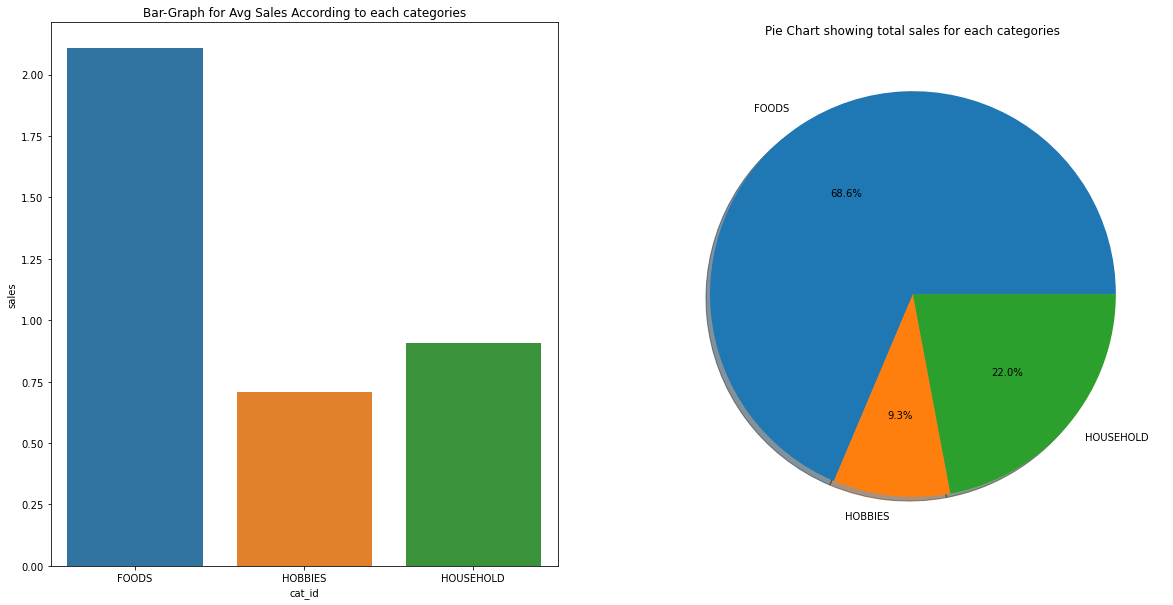

In [21]:
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
#Total Sales for each Category(Bar Graph + Pie chart)
df=data.groupby('cat_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='cat_id',y='sales',data=df)
plt.title("Bar-Graph for Avg Sales According to each categories")

plt.subplot(122)
df=data.groupby('cat_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.pie(df['perc'].values,labels=df['cat_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each categories")
plt.show()

**OBSERVATION**
1. Average and total sales for FOODS type is maximum

<h3> B. Bargraph for Average sales for each State & Pie chart showing percentage of sales for each State</h3>

<b>Train</b>

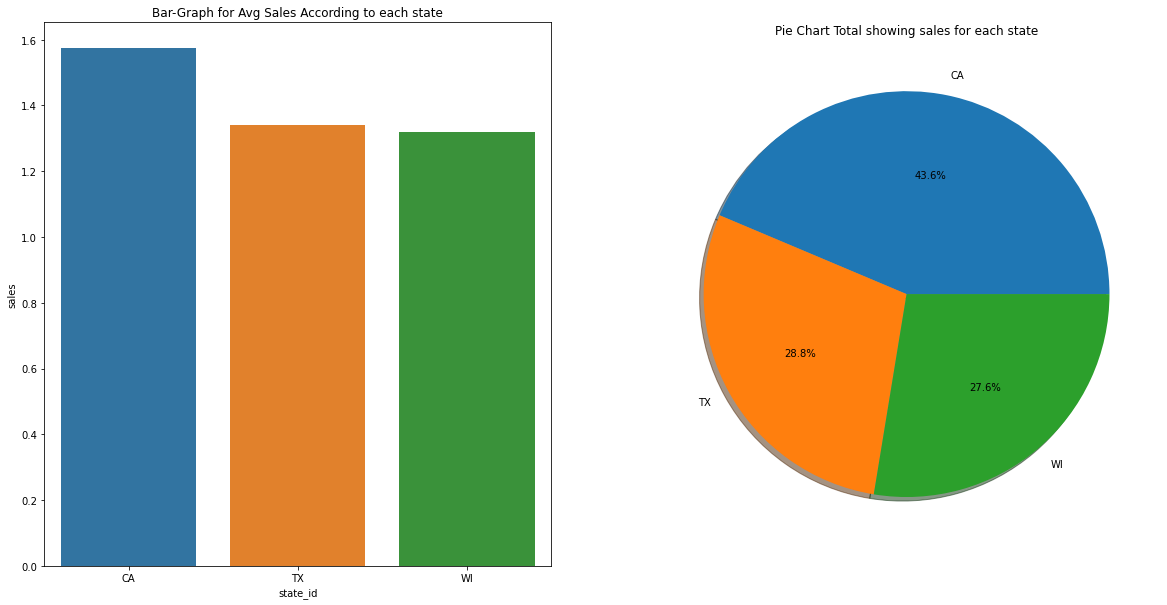

In [23]:
#Total Sales for each State(Barplot+Pie Chart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
df=data.groupby('state_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='state_id',y='sales',data=df)
plt.title("Bar-Graph for Avg Sales According to each state")

df=data.groupby('state_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['state_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart Total showing sales for each state")
plt.show()

**OBSERVATION**
1. Average and Total Sales in state of California is maximum.

<h3> C. Bargraph for Average sales for each Store & Pie chart showing percentage of sales for each Store</h3>

<b>Train</b>

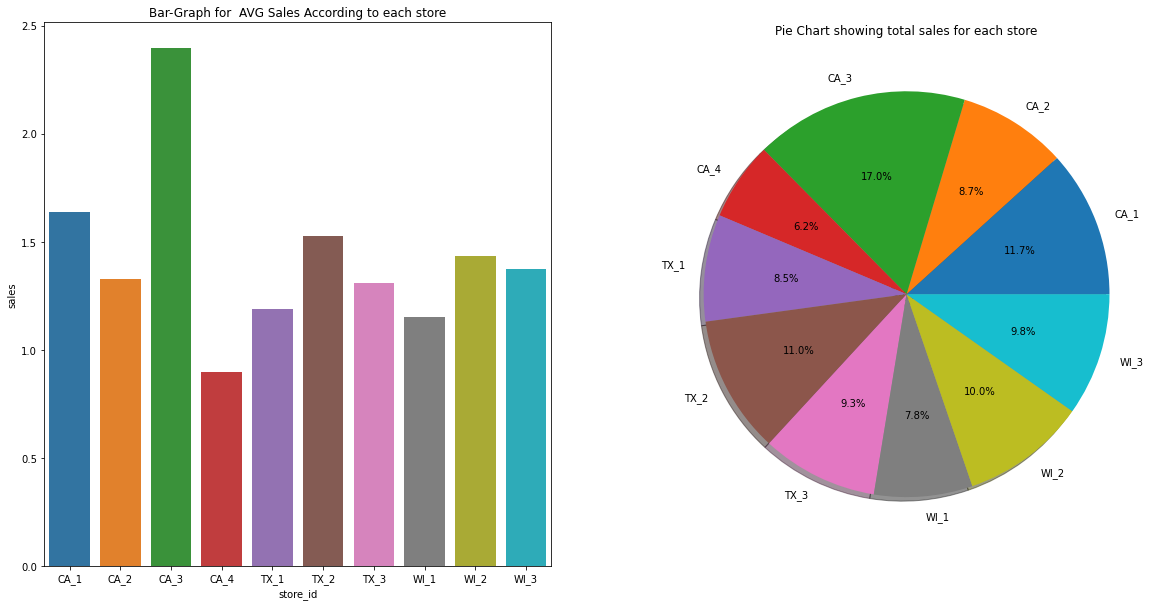

In [25]:
#Total Sales for each store(Bargraph+pieChart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
df=data.groupby('store_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='store_id',y='sales',data=df)
plt.title("Bar-Graph for  AVG Sales According to each store")
df=data.groupby('store_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['store_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each store")

plt.show()

**OBSERVATION**
1. Average and total sales for store CA_3 is maximum.

<h3> D. Bargraph for Average sales for each Weekday & Pie chart showing percentage of sales for each Department</h3>

<b>Train</b>

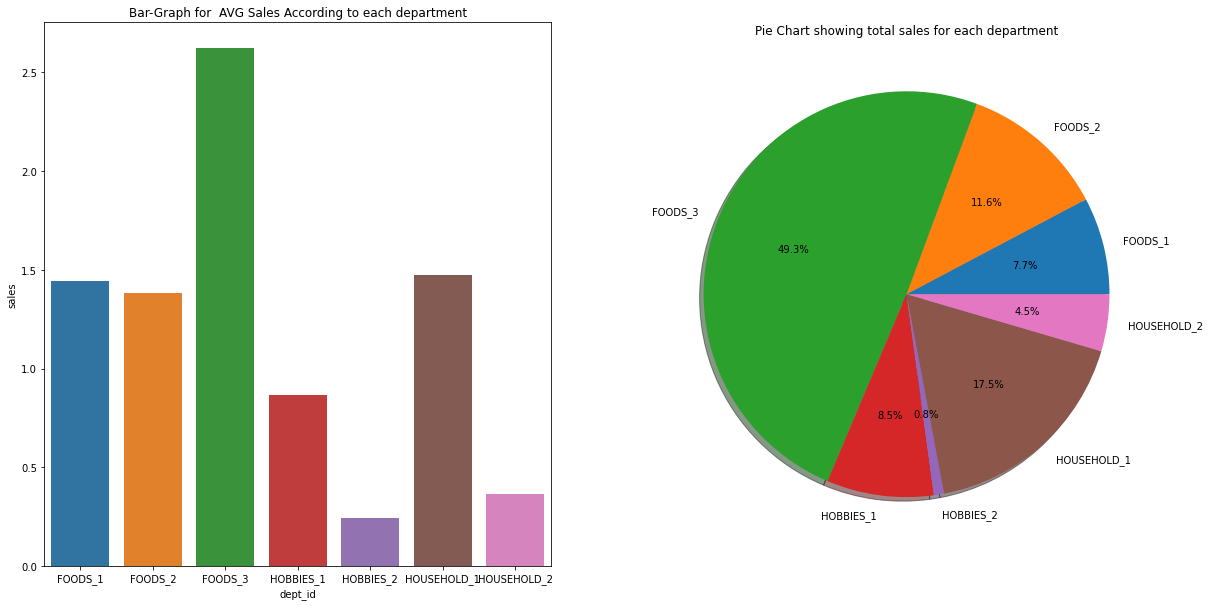

In [27]:
#Total Sales for each store(Bargraph+pieChart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
df=data.groupby('dept_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='dept_id',y='sales',data=df)
plt.title("Bar-Graph for  AVG Sales According to each department")
df=data.groupby('dept_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['dept_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each department")

plt.show()

**OBSERVATION**
1. For HOBBIES_2 department sales is lowest.
2. For FOODS_3 department sales is highest.
3. Almost 50% of sales are done by FOODS_3 department.

<h3> E. Bargraph for Average sales for each Weekday & Pie chart showing percentage of sales for each Week</h3>

<b>Train</b>

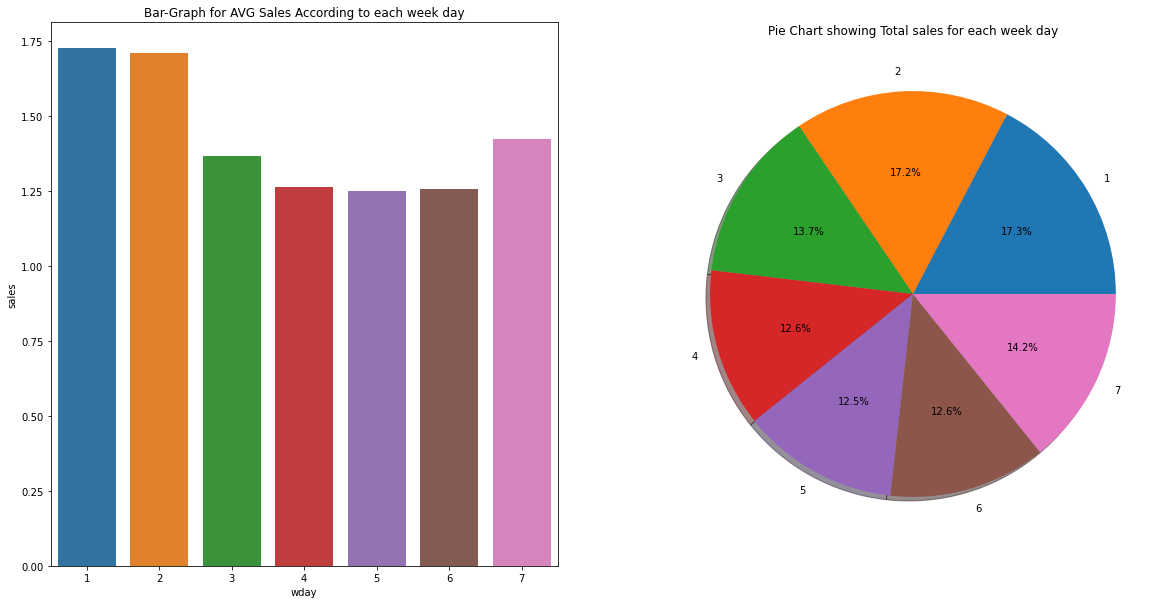

In [29]:
#Total Sales for each day of week(Barplot+PieChart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
df=data.groupby('wday').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='wday',y='sales',data=df)
plt.title("Bar-Graph for AVG Sales According to each week day")

df=data.groupby('wday').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['wday'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing Total sales for each week day")

plt.show()

**OBSERVATION**
1. Clearly sales are more on weekends than normal days.
2. So we must try out to use this weekday feature while training our models.

<h3> F. Bargraph for Average sales for each Month & Pie chart showing percentage of sales for each Month</h3>

<b>Train</b>

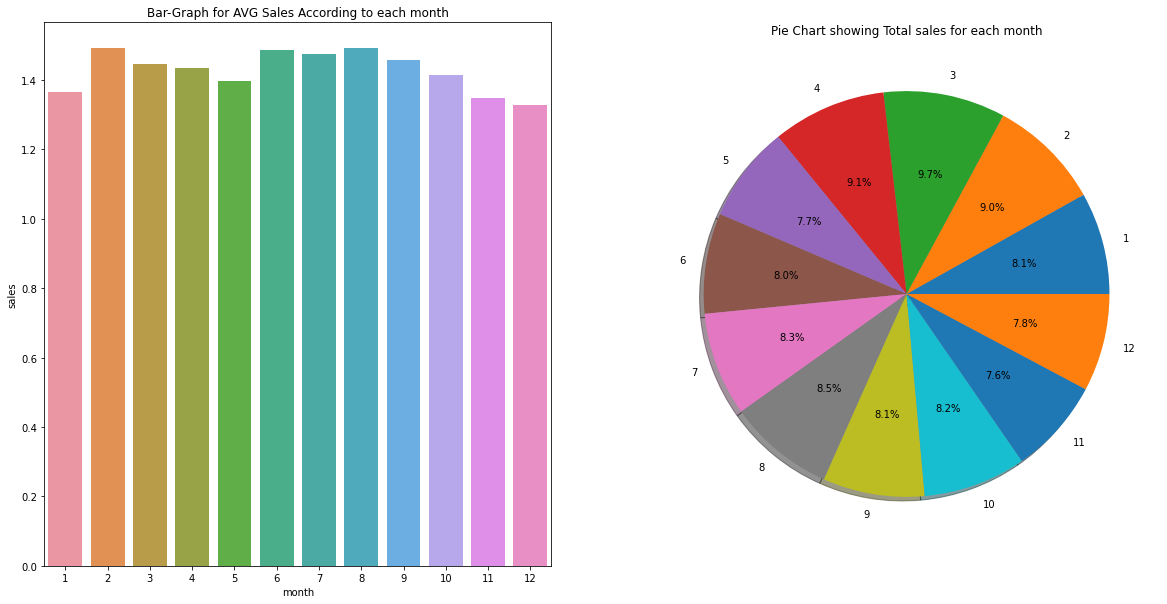

In [31]:
#Total Sales for each month(Barplot+pie chart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
df=data.groupby('month').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='month',y='sales',data=df)
plt.title("Bar-Graph for AVG Sales According to each month")

df=data.groupby('month').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['month'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing Total sales for each month")

plt.show()

**OBSERVATION**
1. Average sales for Month of February(2) is most.

<h3> G. Bargraph for Average sales for each year & Pie chart showing percentage of sales for each year</h3>

<b>Train</b>

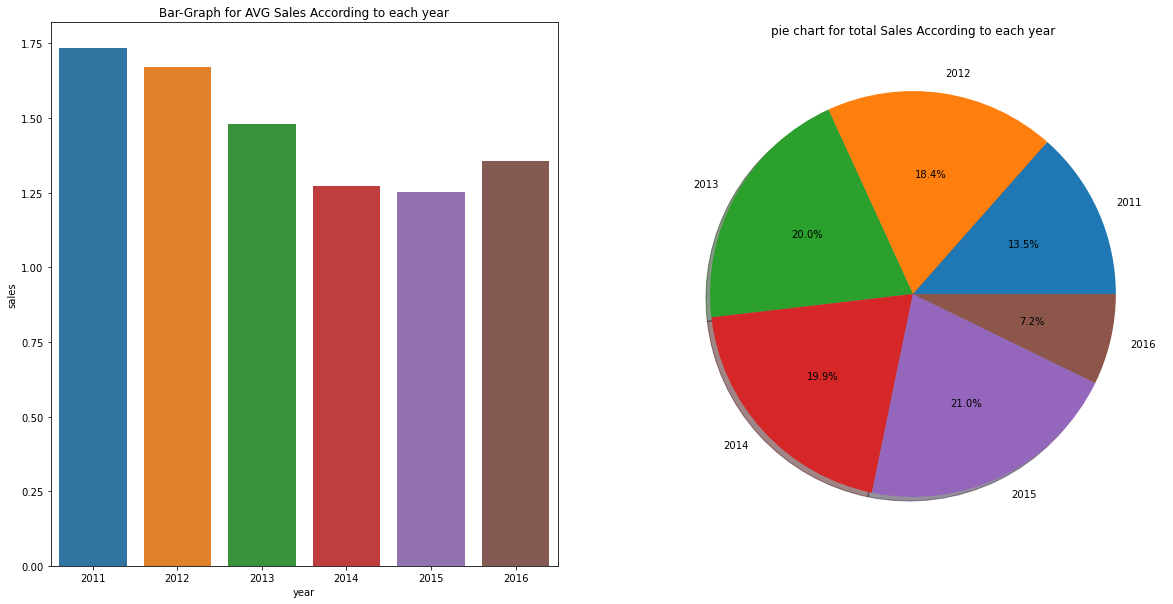

In [33]:
#Total Sales for each year(bar plot+pie chart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

df=data.groupby('year').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)

sns.barplot(x='year',y='sales',data=df)
plt.title("Bar-Graph for AVG Sales According to each year")

plt.subplot(122)
df=data.groupby('year').sum()
df.reset_index(level=0,inplace=True)
df['year_avg']=df['sales']/sum(df['sales'].values)*100
plt.pie(df['year_avg'].values,labels=df['year'].values,shadow=True,autopct='%1.1f%%')

plt.title("pie chart for total Sales According to each year")
plt.show()

**OBSERVATION**
1. Average sales for year 2015 is least.
2. Average sales for year 2011 is maximum.
3. Total sales are maximum in year 2013

<h3> H.Bargraph for Average sales according to snap_ca value & Pie chart showing percentage of sales according to snap_ca value </h3>

<b>Train</b>

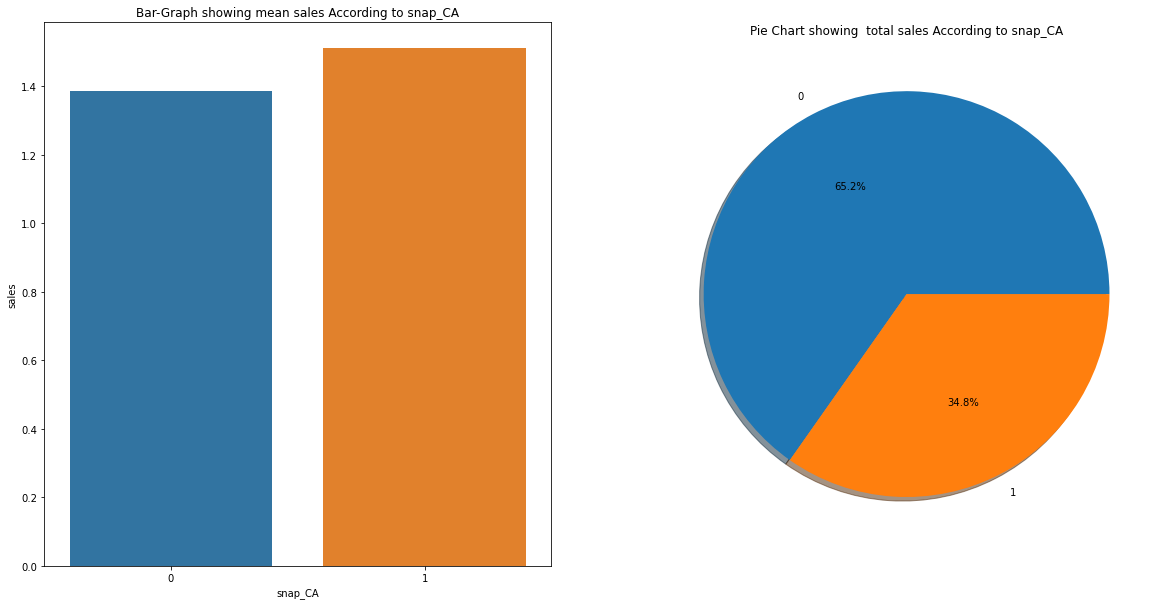

In [35]:
#sales Variation according to snap_CA(Barplot+pie chart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

df=data.groupby('snap_CA').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='snap_CA',y='sales',data=df)
plt.title("Bar-Graph showing mean sales According to snap_CA")

df=data.groupby('snap_CA').sum()
df.reset_index(level=0,inplace=True)
df['snap']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['snap'].values,labels=df['snap_CA'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing  total sales According to snap_CA")

plt.show()

**OBSERVATION**
1. We get that when we provide snap average sales is more than without snap in California.

<h3> I.Bargraph for Average sales according to snap_tx value & Pie chart showing percentage of sales according to snap_tx value </h3>

<b>Train</b>

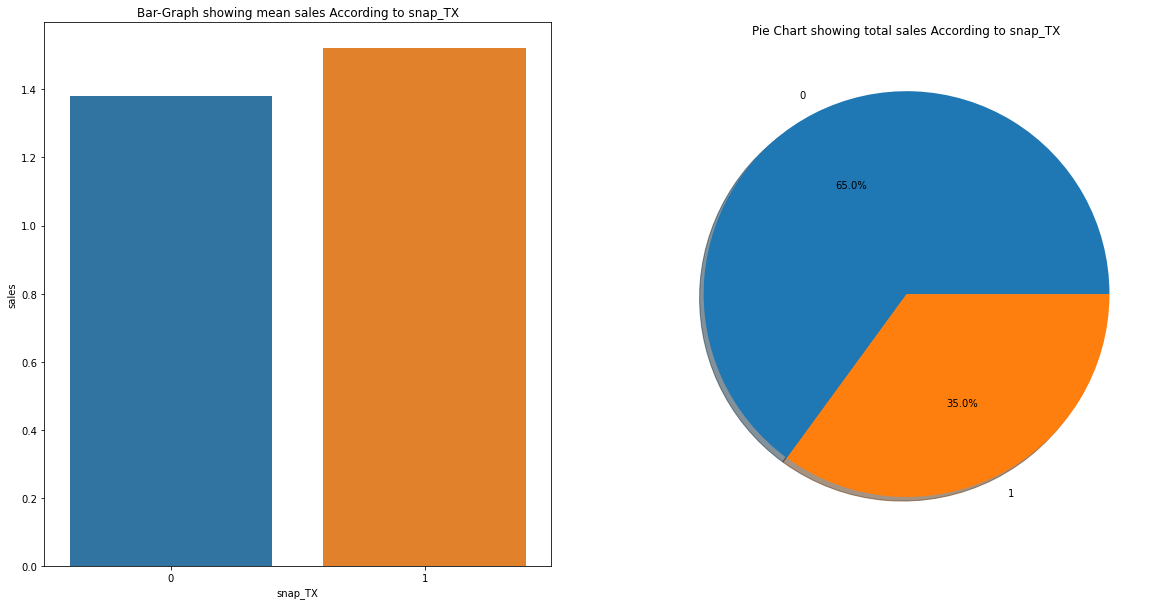

In [37]:
#sales Variation according to snap_TX(Barplot+pie chart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

df=data.groupby('snap_TX').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='snap_TX',y='sales',data=df)
plt.title("Bar-Graph showing mean sales According to snap_TX")

df=data.groupby('snap_TX').sum()
df.reset_index(level=0,inplace=True)
df['snap']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['snap'].values,labels=df['snap_TX'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales According to snap_TX")

plt.show()

**OBSERVATION**
1. We get that when we provide snap average sales is more than without snap in Texas.

<h3> J.Bargraph for Average sales according to snap_wi value & Pie chart showing percentage of sales according to snap_wi value </h3>

<b>Train</b>

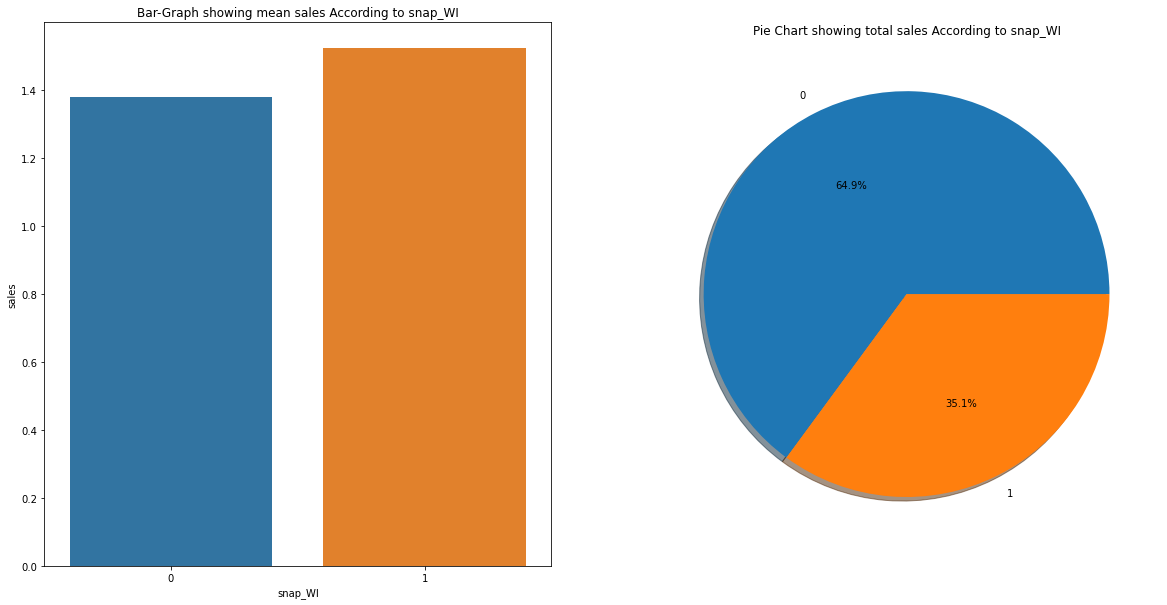

In [39]:
#sales Variation according to snap_WI(Barplot+pie chart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

df=data.groupby('snap_WI').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='snap_WI',y='sales',data=df)
plt.title("Bar-Graph showing mean sales According to snap_WI")

df=data.groupby('snap_WI').sum()
df.reset_index(level=0,inplace=True)
df['snap']=df['sales']/sum(df['sales'].values)*100
plt.subplot(122)
plt.pie(df['snap'].values,labels=df['snap_WI'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales According to snap_WI")

plt.show()

**OBSERVATION**
1. We get that when we provide snap average sales is more than without snap in Wisconsin.

<h3> K.Bargraph for Average sales according to 2 event types & Pie chart showing percentage of sales according to 2 event types </h3>

<b>Train</b>

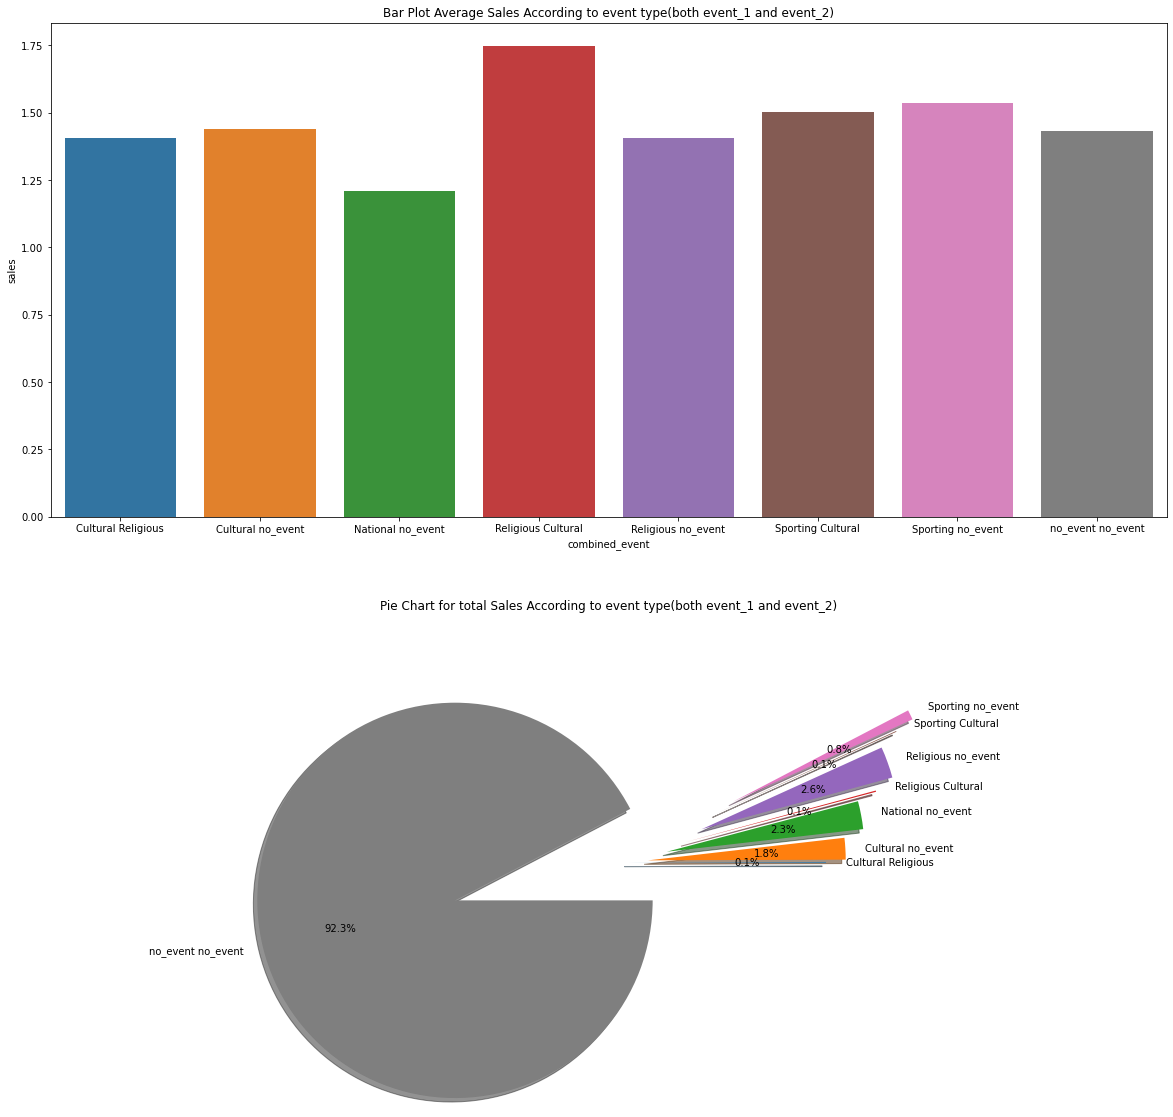

In [41]:
#Sales According to Event_type(both bar graph and pie chart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

df=data.groupby(['event_type_1','event_type_2']).mean()
df.reset_index(level=[0,1],inplace=True)
df['combined_event']=df['event_type_1']+" "+df['event_type_2']
plt.figure(figsize=(20,20))
plt.subplot(211)
sns.barplot(x='combined_event',y='sales',data=df)
plt.title("Bar Plot Average Sales According to event type(both event_1 and event_2)")
df=data.groupby(['event_type_1','event_type_2']).sum()
df.reset_index(level=[0,1],inplace=True)
df['combined_event']=df['event_type_1']+" "+df['event_type_2']
plt.subplot(212)
df['sales_total']=df['sales']/sum(df['sales'].values)*100
explode = (0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8)
plt.pie(df['sales_total'].values,labels=df['combined_event'].values,shadow=True,autopct='%1.1f%%',explode=explode)
plt.title("Pie Chart for total Sales According to event type(both event_1 and event_2)")
plt.show()

**OBSERVATION**
1. Average sales are maximum when we have 2 events of Religious and Cultural type.
2. Thus sales get impacted according to event type.

<h3>From all these plots we get that both train and test data have same distribution</h3>
<b>For Test data while training model we will use data of only last 28 days</b>

<h2>2. Last 30 Days Sales According to Stores for various products</h2>

<h3>A. Sales of last 30 days for all stores of Wisconsin for item FOODS_3_827</h3>

<b>Train</b>

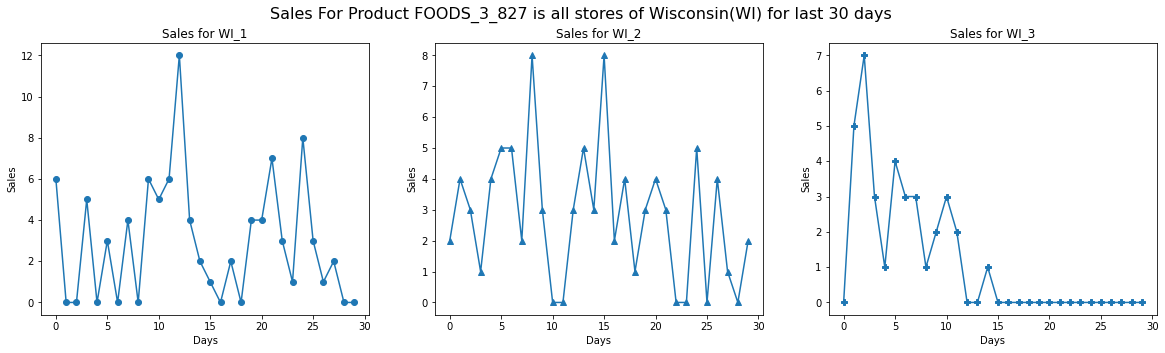

In [43]:
df1=data[(data['item_id']=='FOODS_3_827')&(data['store_id']=='WI_1')]
df2=data[(data['item_id']=='FOODS_3_827')&(data['store_id']=='WI_2')]
df3=data[(data['item_id']=='FOODS_3_827')&(data['store_id']=='WI_3')]

df1=df1.sort_values(by='date')
df2=df2.sort_values(by='date')
df3=df3.sort_values(by='date')


plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(df1['sales'].values[-30:],marker="o")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Sales for WI_1")

plt.subplot(132)
plt.plot(df2['sales'].values[-30:],marker="^")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Sales for WI_2")

plt.subplot(133)
plt.plot(df3['sales'].values[-30:],marker="P")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Sales for WI_3")


plt.suptitle("Sales For Product FOODS_3_827 is all stores of Wisconsin(WI) for last 30 days",fontsize=16)
plt.show()

<h3>B. Sales of last 30 days for all stores of California for item HOOBIES_1_008</h3>

<b>Train</b>

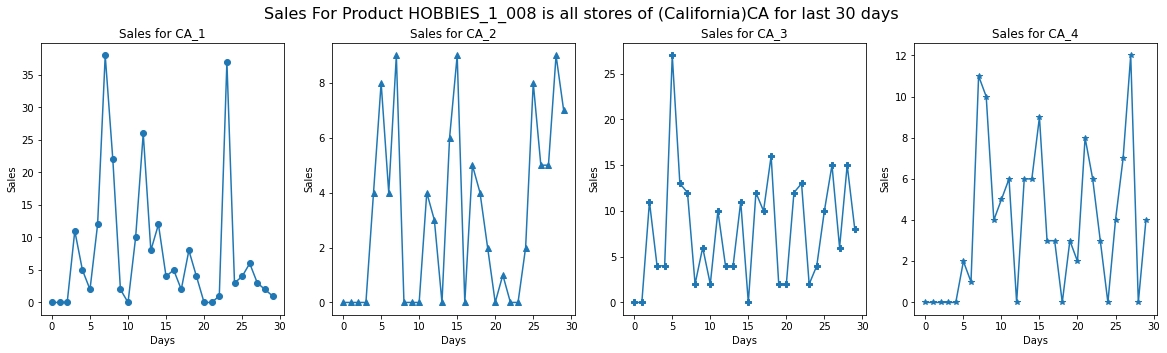

In [45]:
#Now visualse sales for last 30 days for item HOBBIES_1_001 in state CA
df1=data[(data['item_id']=='HOBBIES_1_008')&(data['store_id']=='CA_1')]
df2=data[(data['item_id']=='HOBBIES_1_008')&(data['store_id']=='CA_2')]
df3=data[(data['item_id']=='HOBBIES_1_008')&(data['store_id']=='CA_3')]
df4=data[(data['item_id']=='HOBBIES_1_008')&(data['store_id']=='CA_4')]


df1=df1.sort_values(by='date')
df2=df2.sort_values(by='date')
df3=df3.sort_values(by='date')
df4=df4.sort_values(by='date')


plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(df1['sales'].values[-30:],marker="o")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Sales for CA_1")

plt.subplot(142)
plt.plot(df2['sales'].values[-30:],marker="^")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Sales for CA_2")

plt.subplot(143)
plt.plot(df3['sales'].values[-30:],marker="P")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Sales for CA_3")

plt.subplot(144)
plt.plot(df4['sales'].values[-30:],marker="*")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Sales for CA_4")
plt.suptitle("Sales For Product HOBBIES_1_008 is all stores of (California)CA for last 30 days",fontsize=16)
plt.show()

<h3>C. Sales of last 30 days for all stores of Texas for item HOUSEHOLD_1_526</h3>

<b>Train</b>

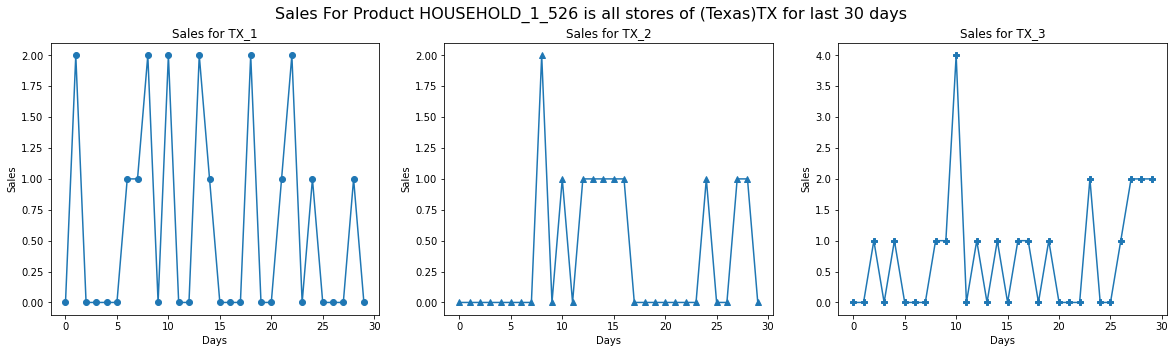

In [47]:
#Now visualse sales for last 30 days for item HOUSEHOLD_2_516 in state CA
df1=data[(data['item_id']=='HOUSEHOLD_1_526')&(data['store_id']=='TX_1')]
df2=data[(data['item_id']=='HOUSEHOLD_1_526')&(data['store_id']=='TX_2')]
df3=data[(data['item_id']=='HOUSEHOLD_1_526')&(data['store_id']=='TX_3')]



df1=df1.sort_values(by='date')
df2=df2.sort_values(by='date')
df3=df3.sort_values(by='date')


plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(df1['sales'].values[-30:],marker="o")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Sales for TX_1")

plt.subplot(132)
plt.plot(df2['sales'].values[-30:],marker="^")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Sales for TX_2")

plt.subplot(133)
plt.plot(df3['sales'].values[-30:],marker="P")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Sales for TX_3")

plt.suptitle("Sales For Product HOUSEHOLD_1_526 is all stores of (Texas)TX for last 30 days",fontsize=16)
plt.show()

<h2>3. Sales According to year & month for Various States</h2>

<b>Train</b>

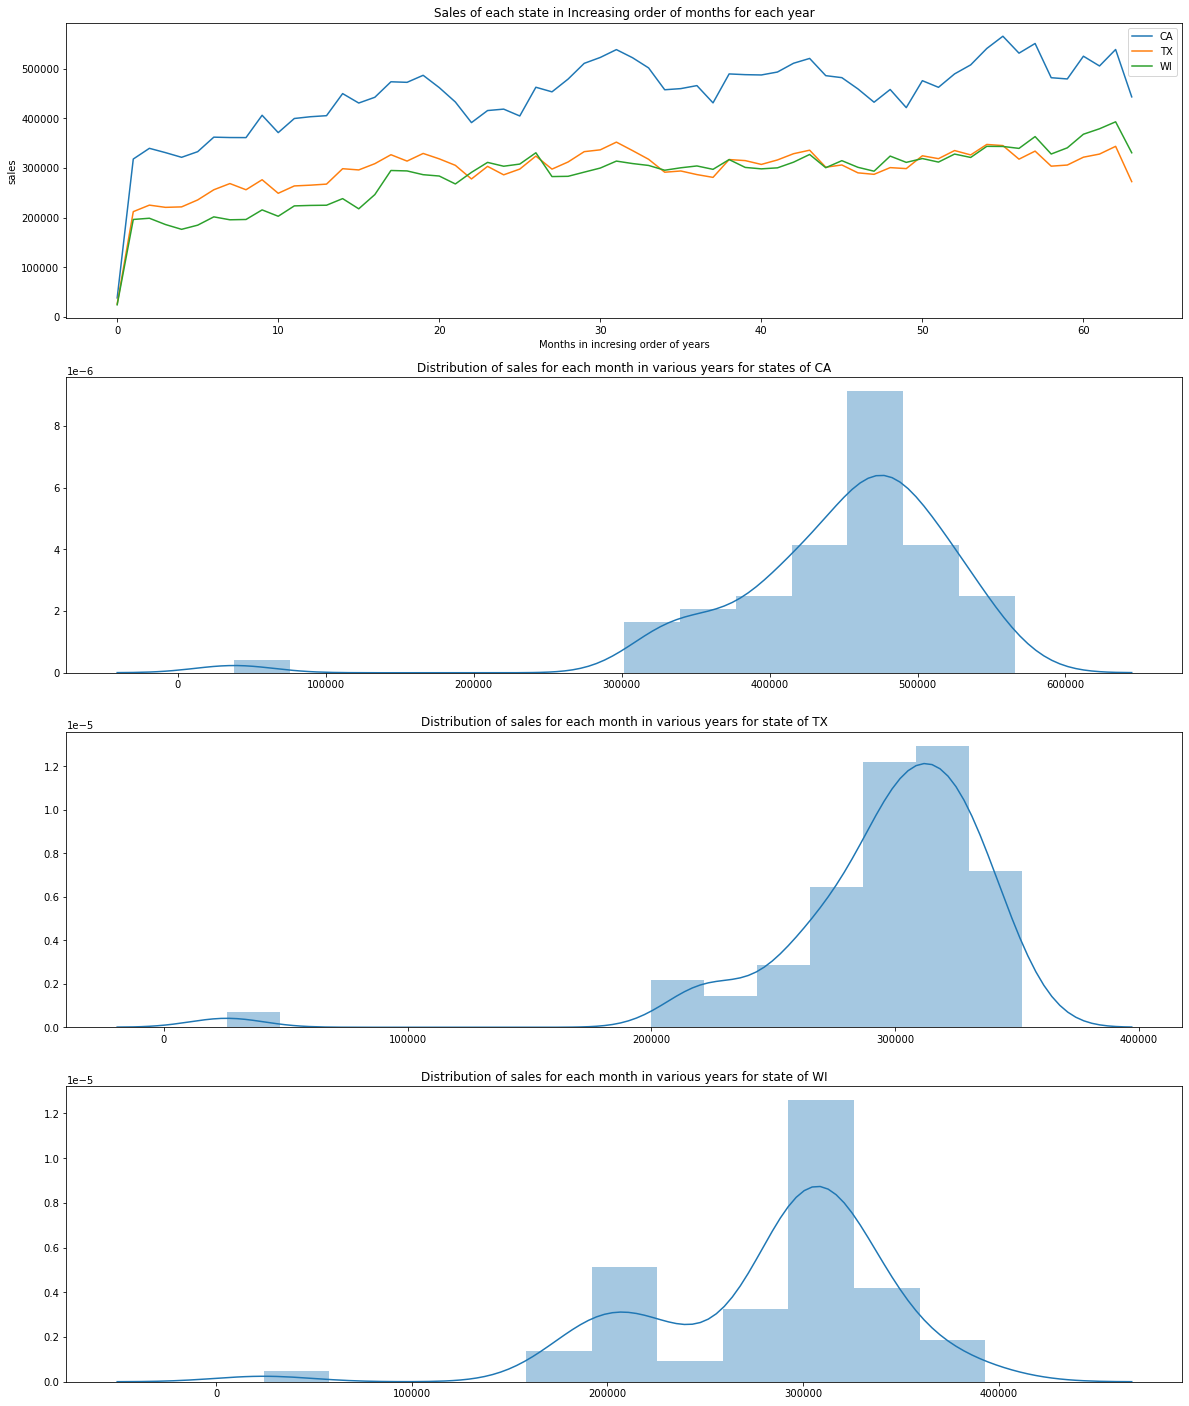

In [49]:
df=data.groupby(['year','month','state_id']).sum()
df.reset_index(level=[0,1,2],inplace=True)
plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(df[df['state_id']=="CA"]['sales'].values,label="CA")
plt.plot(df[df['state_id']=="TX"]['sales'].values,label="TX")
plt.plot(df[df['state_id']=="WI"]['sales'].values,label="WI")
plt.xlabel('Months in incresing order of years')
plt.ylabel('sales')
plt.title("Sales of each state in Increasing order of months for each year")
plt.legend()

plt.subplot(412)
sns.distplot(df[df['state_id']=="CA"]['sales'].values)
plt.title("Distribution of sales for each month in various years for states of CA")

plt.subplot(413)
sns.distplot(df[df['state_id']=="TX"]['sales'].values)
plt.title("Distribution of sales for each month in various years for state of TX")

plt.subplot(414)
sns.distplot(df[df['state_id']=="WI"]['sales'].values)
plt.title("Distribution of sales for each month in various years for state of WI")

plt.show()

**OBSERVATION**
1. clearly sales for CA is more than all 3 states.

<h2>4. Sales According to year & month for Various Product Categories(Train Data)</h2>


<b>Train</b>

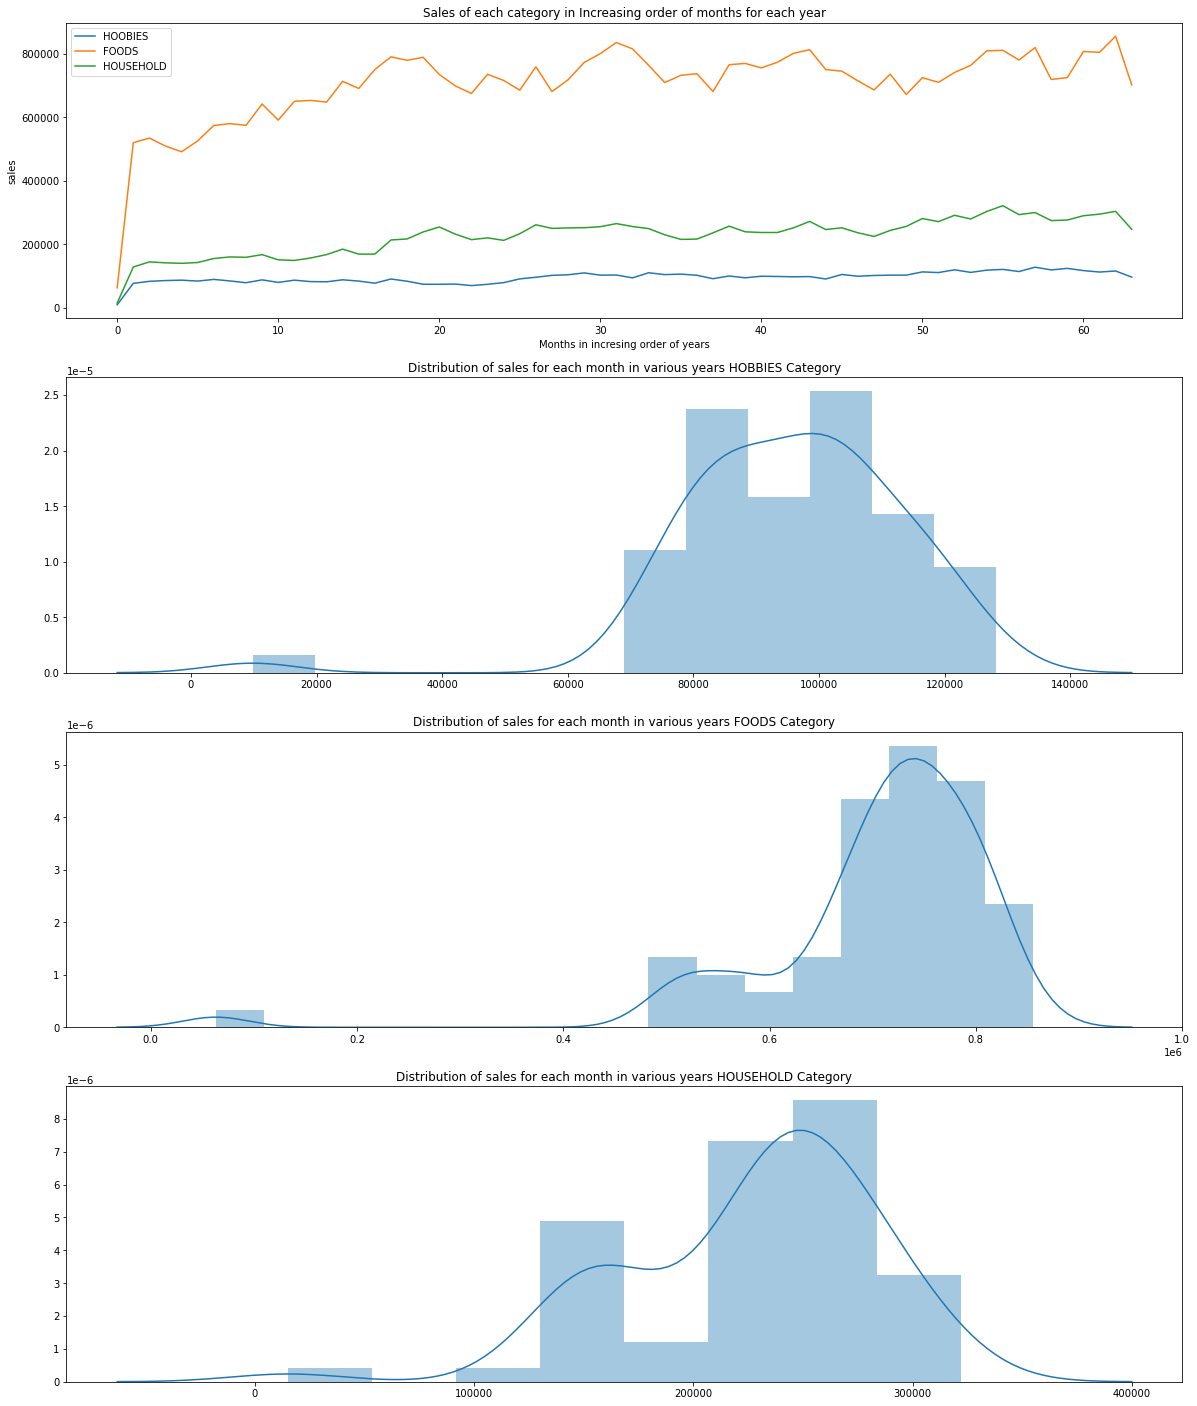

In [51]:
df=data.groupby(['year','month','cat_id']).sum()
df.reset_index(level=[0,1,2],inplace=True)
plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(df[df['cat_id']=="HOBBIES"]['sales'].values,label="HOOBIES")
plt.plot(df[df['cat_id']=="FOODS"]['sales'].values,label="FOODS")
plt.plot(df[df['cat_id']=="HOUSEHOLD"]['sales'].values,label="HOUSEHOLD")
plt.xlabel('Months in incresing order of years')
plt.ylabel('sales')
plt.title("Sales of each category in Increasing order of months for each year")
plt.legend()
plt.subplot(412)
sns.distplot(df[df['cat_id']=="HOBBIES"]['sales'].values)
plt.title("Distribution of sales for each month in various years HOBBIES Category")


plt.subplot(413)
sns.distplot(df[df['cat_id']=="FOODS"]['sales'].values)
plt.title("Distribution of sales for each month in various years FOODS Category")


plt.subplot(414)
sns.distplot(df[df['cat_id']=="HOUSEHOLD"]['sales'].values)
plt.title("Distribution of sales for each month in various years HOUSEHOLD Category")

plt.show()

**OBSERVATION**
1. Sales for FOODS Categories is more.
2. Sales are lowest for HOBBIES Categories.

<h2>Overall Observations</h2>
<br>
1. All plots for train and test data frame are nearly same.<br>
2. We are using last 28 days data of test data for testing model performance.<br>
3. In Next Notebook we will discuss various feature engineering techniques.